In [ ]:
# Move root one step out
import os, sys
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)
    
# Imports and helper functions
import torch
import numpy as np
import torch.nn.functional as F
from Former.Cpp_code.former_class_cpp import FormerGame
from models.PPO_classes import load_ppo_models, get_policy_PPO
import time
import pandas as pd

N_ROWS, N_COLUMNS, N_SHAPES = 9, 7, 4

ppos = load_ppo_models()
actor_large = ppos['actor_large']
actor_small = ppos['actor_small']
critic_large = ppos['critic_large']
critic_small = ppos['critic_small']

def one_hot_encode(board: np.ndarray, S: int) -> np.ndarray:
    H, W = board.shape
    onehot = np.zeros((S+1, H, W), dtype=np.float32)
    for i in range(H):
        for j in range(W):
            v = board[i, j]
            if v < 0:
                onehot[S, i, j] = 1.0
            else:
                onehot[int(v), i, j] = 1.0
    return onehot

def get_mask_from_board(board: np.ndarray) -> np.ndarray:
    """
    Mask moves where there are no shapes.
    """
    flat = board.flatten()
    return (flat != -1)

def get_action_probs_from_board(board: np.ndarray, actor=actor_large) -> np.ndarray:
    """
    Gets action probabilities over board spaces that are not empty.
    """
    obs = one_hot_encode(board, N_SHAPES)
    obs_tensor = torch.as_tensor(obs, dtype=torch.float32, device=device)
    obs_tensor = obs_tensor.unsqueeze(0) 

    with torch.no_grad():
        logits = actor(obs_tensor)        

    mask = get_mask_from_board(board)  
    mask_tensor = torch.as_tensor(mask, device=device).unsqueeze(0)
    logits[~mask_tensor] = float("-inf")

    probs = F.softmax(logits, dim=-1)

    probs_np = probs.cpu().numpy().reshape(N_ROWS, N_COLUMNS)
    return probs_np

device = "cpu"
def evaluate_board_critic(board: np.ndarray, critic=critic_large) -> float:
    """
    Evaluate the board state using the critic.
    """
    obs = one_hot_encode(board, N_SHAPES)
    obs_tensor = torch.as_tensor(obs, dtype=torch.float32, device=device)
    obs_tensor = obs_tensor.unsqueeze(0)
    with torch.no_grad():
        value = critic(obs_tensor)      
    return -float(value.item()) # Negative since reward is negative number of moves remaining

def play_game_greedily_with_actor(board, actor):
    """
    Plays a game greedily using the actor model to select moves.
    """
    
    move_count = 0
    while not FormerGame.is_game_over_static(board):
        policy = get_policy_PPO(board, actor)
        best_action = max(policy.items(), key=lambda x: x[1])[0]
        
        board = np.array(FormerGame.apply_turn_static(board, best_action))
        move_count += 1
    return move_count

def play_game_greedily_with_critic(board, critic=critic_large):
    """
    Plays a game greedily using the critic model to select moves (1-look-ahead).
    """
    move_count = 0
    predictions = []
    while not FormerGame.is_game_over_static(board):
        valid_turns = FormerGame.get_valid_turns_static(board)
        min_val = float('inf')
        best_action = None
        for action in valid_turns:
            new_board = np.array(FormerGame.apply_turn_static(board, action))
            val = evaluate_board_critic(new_board, critic)
            if val < min_val:
                min_val = val
                best_action = action
        board = np.array(FormerGame.apply_turn_static(board, best_action))
        move_count += 1
    return move_count

/Users/espen/Desktop/FormerMSc


# Proximal policy optimization

The notebook is split into two sections:
1. Training
2. Evaluation

### 1. Training

Plot rewards

In [23]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

# point this to your downloaded file
event_file = 'tensorboards/w64d10/events.out.tfevents.1748025998.idun-09-17.3020223-9.0'

# load all scalars (you can also load histograms, images, etc.)
ea = event_accumulator.EventAccumulator(
    event_file,
    size_guidance={ 
        # keep all scalar data
        event_accumulator.SCALARS: 0,  
    }
)
ea.Reload()

# see what scalar tags are in there
tags = ea.Tags()['scalars']

print("Found scalar tags:", tags)

Found scalar tags: ['rollout/ep_len_mean', 'rollout/ep_rew_mean', 'time/fps', 'train/approx_kl', 'train/clip_fraction', 'train/clip_range', 'train/entropy_loss', 'train/explained_variance', 'train/learning_rate', 'train/loss', 'train/policy_gradient_loss', 'train/value_loss']


45417 45417


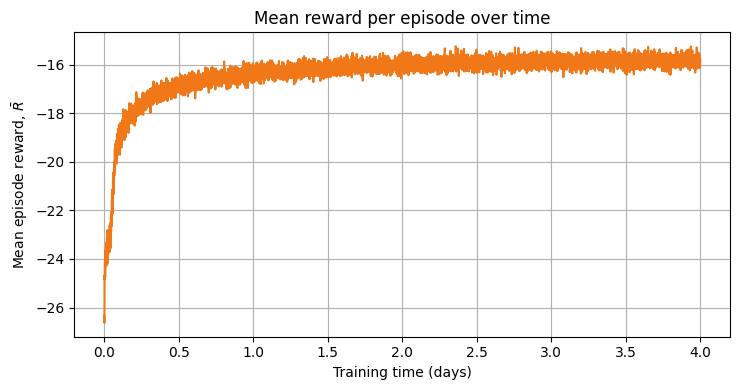

In [27]:
tag      = 'rollout/ep_rew_mean'
events   = ea.Scalars(tag)


wall_times = [e.wall_time for e in events]
t0 = wall_times[0]
elapsed_days = [(wt - t0) /(3600*24) for wt in wall_times]
rewards   = [e.value for e in events]
print(len(elapsed_days), len(rewards))

plt.figure(figsize=(7.5,4))
plt.plot(elapsed_days[::5], rewards[::5], color=plt.cm.YlOrBr(0.6), label=tag)
plt.xlabel('Training time (days)')
plt.ylabel(r'Mean episode reward, $\bar{R}$')
plt.title('Mean reward per episode over time')
plt.grid(True)
plt.tight_layout()
plt.show()

Plot actor / critic loss

/Users/espen/Desktop/masteroppgave_uten_chat/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


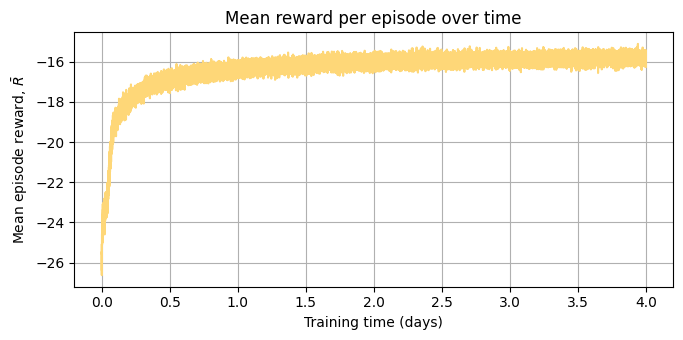

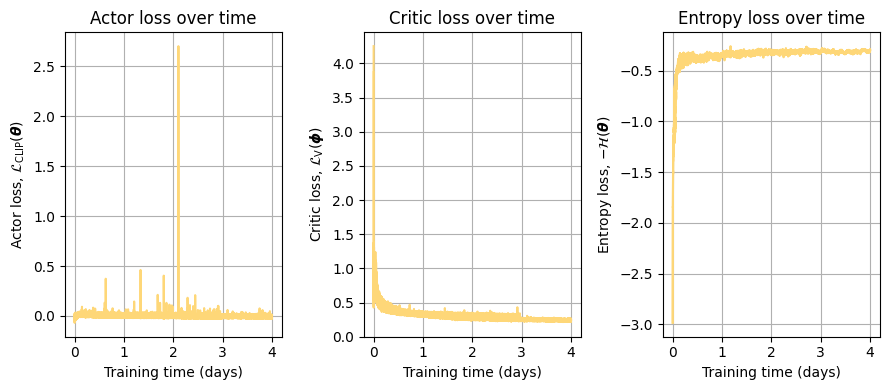

In [1]:
from figure_functions import plot_ppo_training
plot_ppo_training(show=True)

### 2. Evaluation

In [3]:
np.random.seed(22)
boards = np.random.randint(0,4,(1000,9,7))

moves_actor_big  = np.zeros(1000)
times_actor_big  = np.zeros(1000)
moves_critic_big = np.zeros(1000)
times_critic_big = np.zeros(1000)
moves_actor_small  = np.zeros(1000)
times_actor_small  = np.zeros(1000)
moves_critic_small = np.zeros(1000)
times_critic_small = np.zeros(1000)

for j in range(1000):
    board = boards[j]
    
    a = time.time()
    moves_actor_big[j] = play_game_greedily_with_actor(board, actor=actor_large)
    b = time.time()
    times_actor_big[j] = b-a
    
    a = time.time()
    moves_critic_big[j] = play_game_greedily_with_critic(board, critic=critic_large)
    b = time.time()
    times_critic_big[j] = b-a
    
    a = time.time()
    moves_actor_small[j] = play_game_greedily_with_actor(board, actor=actor_small)
    b = time.time()
    times_actor_small[j] = b-a
    
    a = time.time()
    moves_critic_small[j] = play_game_greedily_with_critic(board, critic=critic_small)
    b = time.time()
    times_critic_small[j] = b-a
    
    if (j+1) % 100 == 0:
        print(f"{j+1} boards completed.")

100 boards completed.
200 boards completed.
300 boards completed.
400 boards completed.
500 boards completed.
600 boards completed.
700 boards completed.
800 boards completed.
900 boards completed.
1000 boards completed.


In [4]:
# 1. Create a DataFrame
import pandas as pd
n_boards = 1000
df = pd.DataFrame({
    'Method': [r'$\pi_{\theta,(64,10)}$'] * n_boards +
              [r'$v_{\phi,(64,10)}$'] * n_boards +
              [r'$\pi_{\theta,(32,5)}$'] * n_boards +
              [r'$v_{\phi,(32,5)}$'] * n_boards,
    'Moves':np.concatenate([moves_actor_big, moves_critic_big, moves_actor_small, moves_critic_small]),
    'Time': np.concatenate([times_actor_big, times_critic_big, times_actor_small, times_critic_small])
})

# 2. Save to CSV
csv_path = 'results/6.3_reinforcement/evaluation/ppo_evaluation.csv'
df.to_csv(csv_path, index=False)

# 3. Load it back for verification
csv_path = 'results/6.3_reinforcement/evaluation/ppo_evaluation.csv'
df_loaded = pd.read_csv(csv_path)

# 4. Generate a summary table
summary = df_loaded.groupby('Method').agg(
    Moves_Mean=('Moves', 'mean'),
    Moves_Std=('Moves', 'std'),
    Time_Mean=('Time', 'mean'),
    Time_Std=('Time', 'std')
).reset_index()


# 5. Print the summary nicely
print(summary.to_string(index=False))

                Method  Moves_Mean  Moves_Std  Time_Mean  Time_Std
 $\pi_{\theta,(32,5)}$      15.951   1.804953   0.006233  0.001706
$\pi_{\theta,(64,10)}$      15.756   1.788201   0.012794  0.005269
     $v_{\phi,(32,5)}$      15.259   1.824623   0.062954  0.020869
    $v_{\phi,(64,10)}$      15.107   1.728160   0.162987  0.050653


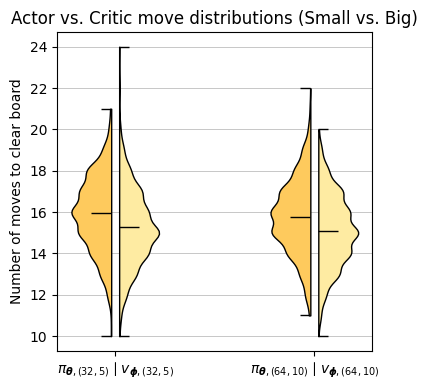

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_ppo_moves(
    ppo_csv,
    save_path=None,
    show=False
):
    # 1) Load data & get unique labels
    df = pd.read_csv(ppo_csv)
    methods = list(df['Method'].unique())
    if len(methods) != 4:
        raise ValueError(f"Expected exactly 4 Method labels, got: {methods}")

    # 2) Identify big vs. small and actor vs. critic
    big_actor_label   = next(m for m in methods if '(64,10)' in m and m.strip().startswith('$\\pi'))
    big_critic_label  = next(m for m in methods if '(64,10)' in m and m.strip().startswith('$v'))
    small_actor_label = next(m for m in methods if '(32,5)' in m and m.strip().startswith('$\\pi'))
    small_critic_label= next(m for m in methods if '(32,5)' in m and m.strip().startswith('$v'))

    # 3) Extract move‐counts
    actor_big_moves   = df.loc[df.Method == big_actor_label,   'Moves'].values
    critic_big_moves  = df.loc[df.Method == big_critic_label,  'Moves'].values
    actor_small_moves = df.loc[df.Method == small_actor_label, 'Moves'].values
    critic_small_moves= df.loc[df.Method == small_critic_label,'Moves'].values

    # 4) Styling params
    positions = [1, 2]     # we'll put "small" at pos=1, "big" at pos=2
    w         = 0.4
    offset    = 0.02
    policy_color = plt.cm.YlOrBr(0.35)  # π color
    value_color  = plt.cm.YlOrBr(0.2)   # v color

    fig, ax = plt.subplots(figsize=(4,4))
    ax.grid(axis='y', linewidth=0.5)

    # ======================
    # 5) Draw the “small” split‐violin at x=1 (positions[0])
    pos = positions[0]

    # 5a) Actor‐small (left half)
    parts_pol_small = ax.violinplot(
        [actor_small_moves],
        positions=[pos - offset],
        widths=w,
        showmeans=False,
        showextrema=False
    )
    for pc in parts_pol_small['bodies']:
        verts  = pc.get_paths()[0].vertices
        center = pos - offset
        verts[:,0] = np.minimum(verts[:,0], center)
        pc.set_facecolor(policy_color)
        pc.set_edgecolor('black')
        pc.set_linewidth(1)
        pc.set_alpha(1)

    # 5b) Critic‐small (right half)
    parts_val_small = ax.violinplot(
        [critic_small_moves],
        positions=[pos + offset],
        widths=w,
        showmeans=False,
        showextrema=False
    )
    for pc in parts_val_small['bodies']:
        verts  = pc.get_paths()[0].vertices
        center = pos + offset
        verts[:,0] = np.maximum(verts[:,0], center)
        pc.set_facecolor(value_color)
        pc.set_edgecolor('black')
        pc.set_linewidth(1)
        pc.set_alpha(1)

    # 5c) Custom mean/min/max bars for small
    m_pol_small   = actor_small_moves.mean()
    max_pol_small = actor_small_moves.max()
    min_pol_small = actor_small_moves.min()
    x0_pol_s, x1_pol_s = pos - offset - w/4, pos - offset
    ax.hlines(m_pol_small,   x0_pol_s,          x1_pol_s,          color='black', linewidth=1)
    ax.hlines(max_pol_small, x0_pol_s + w/8,    x1_pol_s,          color='black', linewidth=1)
    ax.hlines(min_pol_small, x0_pol_s + w/8,    x1_pol_s,          color='black', linewidth=1)

    m_val_small   = critic_small_moves.mean()
    max_val_small = critic_small_moves.max()
    min_val_small = critic_small_moves.min()
    x0_val_s, x1_val_s = pos + offset, pos + offset + w/4
    ax.hlines(m_val_small,   x0_val_s,          x1_val_s,          color='black', linewidth=1)
    ax.hlines(max_val_small, x0_val_s,          x1_val_s - w/8,    color='black', linewidth=1)
    ax.hlines(min_val_small, x0_val_s,          x1_val_s - w/8,    color='black', linewidth=1)

    # ======================
    # 6) Draw the “big” split‐violin at x=2 (positions[1])
    pos = positions[1]

    # 6a) Actor‐big (left half)
    parts_pol_big = ax.violinplot(
        [actor_big_moves],
        positions=[pos - offset],
        widths=w,
        showmeans=False,
        showextrema=False
    )
    for pc in parts_pol_big['bodies']:
        verts  = pc.get_paths()[0].vertices
        center = pos - offset
        verts[:,0] = np.minimum(verts[:,0], center)
        pc.set_facecolor(policy_color)
        pc.set_edgecolor('black')
        pc.set_linewidth(1)
        pc.set_alpha(1)

    # 6b) Critic‐big (right half)
    parts_val_big = ax.violinplot(
        [critic_big_moves],
        positions=[pos + offset],
        widths=w,
        showmeans=False,
        showextrema=False
    )
    for pc in parts_val_big['bodies']:
        verts  = pc.get_paths()[0].vertices
        center = pos + offset
        verts[:,0] = np.maximum(verts[:,0], center)
        pc.set_facecolor(value_color)
        pc.set_edgecolor('black')
        pc.set_linewidth(1)
        pc.set_alpha(1)

    # 6c) Custom mean/min/max bars for big
    m_pol_big   = actor_big_moves.mean()
    max_pol_big = actor_big_moves.max()
    min_pol_big = actor_big_moves.min()
    x0_pol_b, x1_pol_b = pos - offset - w/4, pos - offset
    ax.hlines(m_pol_big,   x0_pol_b,          x1_pol_b,          color='black', linewidth=1)
    ax.hlines(max_pol_big, x0_pol_b + w/8,    x1_pol_b,          color='black', linewidth=1)
    ax.hlines(min_pol_big, x0_pol_b + w/8,    x1_pol_b,          color='black', linewidth=1)

    m_val_big   = critic_big_moves.mean()
    max_val_big = critic_big_moves.max()
    min_val_big = critic_big_moves.min()
    x0_val_b, x1_val_b = pos + offset, pos + offset + w/4
    ax.hlines(m_val_big,   x0_val_b,          x1_val_b,          color='black', linewidth=1)
    ax.hlines(max_val_big, x0_val_b,          x1_val_b - w/8,    color='black', linewidth=1)
    ax.hlines(min_val_big, x0_val_b,          x1_val_b - w/8,    color='black', linewidth=1)

    # ======================
    # 7) Final formatting
    ax.set_xticks(positions)
    ax.set_xticklabels([
        r"$\pi_{\boldsymbol{\theta},(32,5)}\mid v_{\boldsymbol{\phi},(32,5)}$",
        r"$\pi_{\boldsymbol{\theta},(64,10)}\mid v_{\boldsymbol{\phi},(64,10)}$"
    ])
    ax.set_ylabel("Number of moves to clear board")
    ax.set_title("Actor vs. Critic move distributions (Small vs. Big)")
    ax.set_axisbelow(True)
    plt.tight_layout()

    # 8) Save/show
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    if show:
        plt.show()


plot_ppo_moves(
    ppo_csv="results/6.3_reinforcement/evaluation/ppo_evaluation.csv",
    show=True
)

color=plt.cm.YlOrBr(0.6)

Calibration: Only shown for (64,10), but the same can be done for (32,5).

In [5]:
def play_game_greedily_with_actor(board):
    move_count = 0
    while not FormerGame.is_game_over_static(board):
        policy = get_policy_PPO(board)
        best_action = max(policy.items(), key=lambda x: x[1])[0]
        
        board = np.array(FormerGame.apply_turn_static(board, best_action))
        move_count += 1
    return move_count

def actor_critic_calibration_one_game(board):
    predictions = []
    move_count = 0
    while not FormerGame.is_game_over_static(board):
        predictions.append(evaluate_board_critic(board))
        policy = get_policy_PPO(board)
        best_action = max(policy.items(), key=lambda x: x[1])[0]
        board = np.array(FormerGame.apply_turn_static(board, best_action))
        move_count += 1
    moves_remaining = np.arange(move_count, 0, -1)
    return moves_remaining, predictions

In [ ]:
np.random.seed(22)
N = 10_000

# Preallocate with NaNs
predictions = np.zeros((N, 20)) * np.nan

boards = np.random.randint(0, 4, (N, 9, 7))
for n in range(N):
    board = boards[n]
    actual_sols, preds = actor_critic_calibration_one_game(board)
    for i, true_moves in enumerate(actual_sols):
        if true_moves <= 20:
            # store the critic's prediction at the bin = true_moves
            predictions[n, true_moves - 1] = preds[i]
    if (n + 1) % 100 == 0:
        print(f"{n+1} boards finished")

# Save to disk (compressed .npz with a 'predictions' field)
save_path = "results/6.3_reinforcement/evaluation/ppo_critic_calib_data.npz"
np.savez_compressed(save_path, predictions=predictions)
print(f"Saved predictions to {save_path}")

100 boards finished
200 boards finished
300 boards finished
400 boards finished
500 boards finished
600 boards finished
700 boards finished
800 boards finished
900 boards finished
1000 boards finished
1100 boards finished
1200 boards finished
1300 boards finished
1400 boards finished
1500 boards finished
1600 boards finished
1700 boards finished
1800 boards finished
1900 boards finished
2000 boards finished
2100 boards finished
2200 boards finished
2300 boards finished
2400 boards finished
2500 boards finished
2600 boards finished
2700 boards finished
2800 boards finished
2900 boards finished
3000 boards finished
3100 boards finished
3200 boards finished
3300 boards finished
3400 boards finished
3500 boards finished
3600 boards finished
3700 boards finished
3800 boards finished
3900 boards finished
4000 boards finished
4100 boards finished
4200 boards finished
4300 boards finished
4400 boards finished
4500 boards finished
4600 boards finished
4700 boards finished
4800 boards finished
4

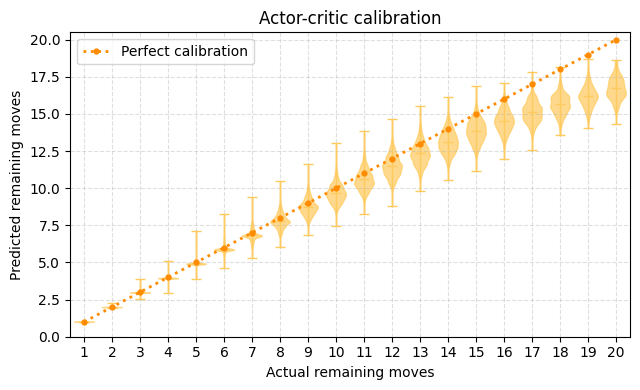

In [6]:
from figure_functions import plot_ppo_critic_calibration
plot_ppo_critic_calibration(show=True)

In [5]:
# Test on daily boards
import daily_board as db

moves_actor_big  = np.zeros(100)
times_actor_big  = np.zeros(100)
moves_critic_big = np.zeros(100)
times_critic_big = np.zeros(100)
moves_actor_small  = np.zeros(100)
times_actor_small  = np.zeros(100)
moves_critic_small = np.zeros(100)
times_critic_small = np.zeros(100)
board_tuples = db.get_daily_board()

j = 0
for _, bt in board_tuples.items():
    board = boards[j]
    
    a = time.time()
    moves_actor_big[j] = play_game_greedily_with_actor(board, actor=actor_large)
    b = time.time()
    times_actor_big[j] = b-a
    
    a = time.time()
    moves_critic_big[j] = play_game_greedily_with_critic(board, critic=critic_large)
    b = time.time()
    times_critic_big[j] = b-a
    
    a = time.time()
    moves_actor_small[j] = play_game_greedily_with_actor(board, actor=actor_small)
    b = time.time()
    times_actor_small[j] = b-a
    
    a = time.time()
    moves_critic_small[j] = play_game_greedily_with_critic(board, critic=critic_small)
    b = time.time()
    times_critic_small[j] = b-a
    
    if (j+1) % 10 == 0:
        print(f"{j+1} boards completed.")
    j += 1

10 boards completed.
20 boards completed.
30 boards completed.
40 boards completed.
50 boards completed.
60 boards completed.
70 boards completed.
80 boards completed.
90 boards completed.
100 boards completed.


In [ ]:
# 1) Get the best‐known solution lengths for each daily board
board_tuples = db.get_daily_board()
best_actual_sols = [bt[1] for _, bt in board_tuples.items()]
best = np.array(best_actual_sols)

# 2) You should have already filled in these arrays during your loop:
#    moves_actor_big, moves_critic_big, moves_actor_small, moves_critic_small

# 3) Put each new model’s move‐counts into a dictionary:
models = {
    "Actor (large)":  moves_actor_big,
    "Critic (large)": moves_critic_big,
    "Actor (small)":  moves_actor_small,
    "Critic (small)": moves_critic_small,
}

# 4) Choose the range of deviations you want to display (0…10):
deviation_range = range(0, 11)

# 5) Build a table of “# of boards with abs(moves – best) = d” for d=0…10:
table_data = {}
for name, moves in models.items():
    diffs = np.abs(moves - best).astype(int)
    counts = [np.sum(diffs == d) for d in deviation_range]
    table_data[name] = counts

# 6) Turn it into a DataFrame so that rows = Model and columns = Deviation
df = pd.DataFrame(table_data, index=deviation_range).T
df.index.name = "Model"
df.columns.name = "Deviation"

print(df)

Deviation       0   1   2   3   4   5   6   7   8   9   10
Model                                                     
Actor (large)   11  26  23  15  16   5   2   1   1   0   0
Critic (large)  21  27  23  13   7   6   2   1   0   0   0
Actor (small)   14  22  23  17  10   8   4   2   0   0   0
Critic (small)  19  31  13  15  11   5   3   2   1   0   0


In [30]:
# Initial move analysis
from PPO_classes import get_recommended_action_ppo
i = 0
first_actions = []
second_actions = []
third_actions = []
fourth_actions = []
fifth_actions = []
sixth_actions = []

for i in range(10000):
    np.random.seed()
    board = np.random.randint(0,4,(9,7))
    action1 = get_recommended_action_ppo(board, actor_small)
    #action1 = max(pol, key=pol.get)
    first_actions.append(action1[0])
    
    #board = np.array(FormerGame.apply_turn_static(board, action1))
    #pol = get_policy_PPO(board, actor_small)
    #action2 = max(pol, key=pol.get)
    #second_actions.append(action2)
    #
    #board = np.array(FormerGame.apply_turn_static(board, action2))
    #pol = get_policy_PPO(board, actor_small)
    #action3 = max(pol, key=pol.get)
    #third_actions.append(action3)
    #
    #board = np.array(FormerGame.apply_turn_static(board, action3))
    #pol = get_policy_PPO(board, actor_small)
    #action4 = max(pol, key=pol.get)
    #fourth_actions.append(action4)
    #
    #board = np.array(FormerGame.apply_turn_static(board, action4))
    #pol = get_policy_PPO(board, actor_small)
    #action5 = max(pol, key=pol.get)
    #fifth_actions.append(action5)
    #
    #board = np.array(FormerGame.apply_turn_static(board, action5))
    #pol = get_policy_PPO(board, actor_small)
    #action6 = max(pol, key=pol.get)
    #sixth_actions.append(action6)



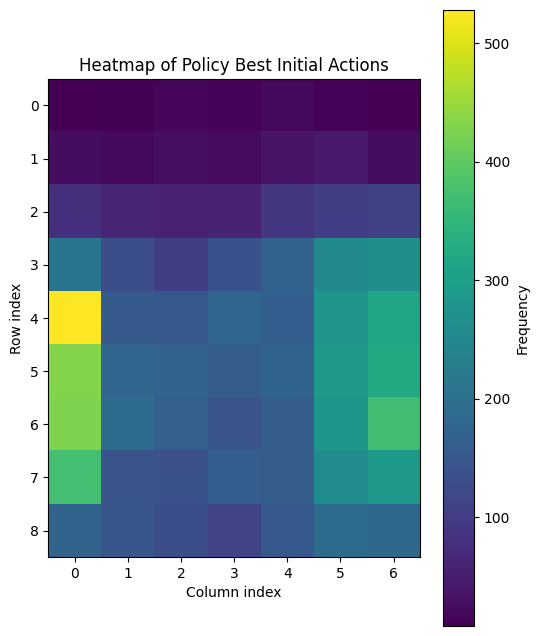

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose `actions` is your precomputed list of best (row, col) actions over 10,000 boards.
# For example:
# actions = [(r0, c0), (r1, c1), ..., (r9999, c9999)]

# 1) Build frequency heatmap
heatmap = np.zeros((9, 7), dtype=int)
for (row, col) in first_actions:
    heatmap[row, col] += 1

# 2) Plot heatmap
plt.figure(figsize=(6, 8))
plt.imshow(heatmap, origin='upper')
plt.colorbar(label='Frequency')
plt.xlabel('Column index')
plt.ylabel('Row index')
plt.title('Heatmap of Policy Best Initial Actions')
plt.xticks(range(7))
plt.yticks(range(9))
plt.show()

